# GOAL

Steps to get there: 
1. Install Dependencies and Setup
2. Perform some data exploration
3. Load data
4. Scale data to be in the correct format for our model
5. Make seperate training, validation, and testing sets
6. Build custom deep learning model (hint add multiple input, output, and hidden layers)
7. Train model (hint hint use the fit() function)
8. Plot performance (how well did we do?!?!?) 
9. Do some quick testing with our own image
10. Save the model


# 1. Install Dependencies and Setup

Labels: targets - the graph pictures

Features/inputs: inputs - in this case, the image. 

Training data - the data we feed to our model. 

Validation data - the data we use to evaluate our model to see how well it trained.

Testing data - the data we use to test our model to see how well it generalizes (i.e. how well it performs on recognizing a fruit.).

In [147]:
import tensorflow as tf
import os

In [148]:
##! ARE YOU A WINDOWS USER OR HAVE A GPU ON YOUR COMPUTER? UNCOMMENT THIS CELL!!!!!!!!!!
# (ew)

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus: 
#     tf.config.experimental.set_memory_growth(gpu, True)

# tf.config.list_physical_devices('GPU')

# 2. Check out our training set

Ok - So, the goal here is going to be to split up our training data in order to train our models 

Like we said in the doc, we need to split our data into training, validation, and testing sets. 

We're going to start by simply writing our directory and checking out what our data looks like. 


In [149]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os


In [ ]:
data_dir = 'train_data'
os.listdir(data_dir)
print(os.listdir(data_dir))

['.DS_Store', 'bad', 'good']


All this cell below is doing is just checking out what our data actually looks like.

(1226, 1684, 4)


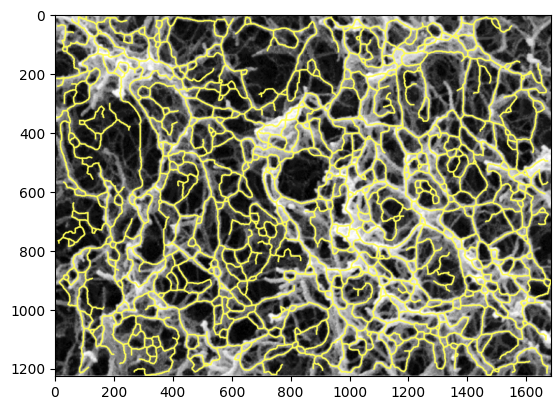

In [151]:
import matplotlib.image as mpimg

img = mpimg.imread('train_data/good/ANF_good1.png')
print(img.shape)
plt.imshow(img)

# 3. Load Data

Cool - so we see what our data looks like. Now we're going to load it into our model. 

In [152]:
import numpy as np
from matplotlib import pyplot as plt

A machine learning model needs to be in the right shape and format in order to be trained. 

In [ ]:
# This formats our data...

train = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  shuffle=True,
  seed=123,               
  image_size=(224,224),
  batch_size=32,
  label_mode='binary',
  validation_split=0.2, 
  subset='training'
)

val = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  shuffle=True,
  seed=123,                
  image_size=(224,224),
  batch_size=32,
  label_mode='binary',
  validation_split=0.2,
  subset='validation'
)



Found 126 files belonging to 2 classes.
Using 101 files for training.
Found 126 files belonging to 2 classes.
Using 25 files for validation.


# 4. Scale Data

1. Our tensorflow model works with values between 0 and 1.
2. Our images give us pixel R, G, B values from 0-255.

Thus, we need to scale our input data down.

In [ ]:
# Hint: Pixel values range from 0-255. We want to scale x to range between 0-1.
# x represents our data, and y represents our class. Therefore, we shouldn't worry about y

# 1) keep / tweak your augmentation block
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.10),
])

# 2) add a normaliser layer
normalise = tf.keras.layers.Rescaling(1./255)

# 3) rebuild the dataset pipeline
train = train.map(lambda x, y: (augment(normalise(x), training=True), y))
val   = val.map(lambda x, y: (normalise(x), y))

# #train = train.map(lambda x,y: (x/255, y))
# train = train.map(lambda x, y: (augment(x, training=True) / 255.0, y))
# val = val.map(lambda x,y: (x/255, y))

In [ ]:
# This will now give us an iterator with our SCALED data
scaled_iterator = train.as_numpy_iterator()
batch = scaled_iterator.next()


# 6. Build Deep Learning Model

In [158]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Flatten, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers

Layers we're looking for: 
Activation, 
MaxPooling2D,
Conv2D,
Dropout,
Flatten,
Dense



In [159]:
# before start

model = Sequential()

model.add(layers.Rescaling(1./255, input_shape=(224, 224, 3)))

model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.BatchNormalization())     
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))             

model.add(layers.Dense(1, activation='sigmoid'))  # final classifier

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [160]:
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',       # watch validation loss
    patience=5,               # stop if it hasn’t improved in 5 epochs
    restore_best_weights=True # roll back to the best epoch 
)

reduce  = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                               factor=0.2,
                                               patience=3)

In [161]:
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_17 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │        50,177 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,017 (289.13 KB)

 Trainable params: 73,889 (288.63 KB)

 Non-trainable params: 128 (512.00 B)

# 8. Train

Now, time to train our model! 

In [162]:
logdir='logs'

In [163]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:

hist = model.fit(train, epochs=3, validation_data=val, callbacks = tensorboard_callback, shuffle = True)
# hist = model.fit(
#     train,
#     epochs=30,                
#     validation_data=val,
#     callbacks=[early, reduce], 
# )

Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step - accuracy: 0.4218 - loss: 0.6942 - val_accuracy: 0.2800 - val_loss: 0.6934
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.5041 - loss: 0.6921 - val_accuracy: 0.2800 - val_loss: 0.6937
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.5282 - loss: 0.6917 - val_accuracy: 0.2800 - val_loss: 0.6941


# 9. Plot Performance

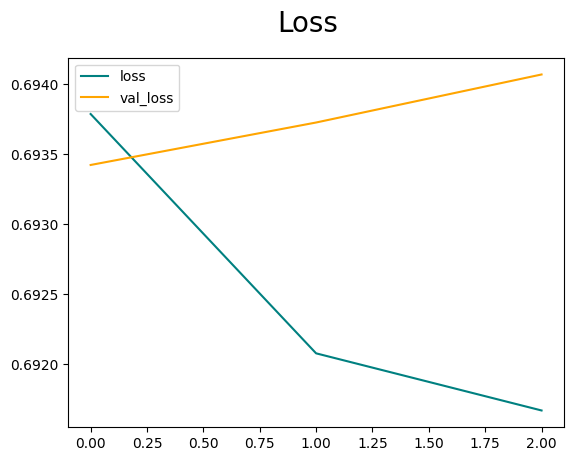

In [165]:
# Show our loss + validation loss (should be decreasing)
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()




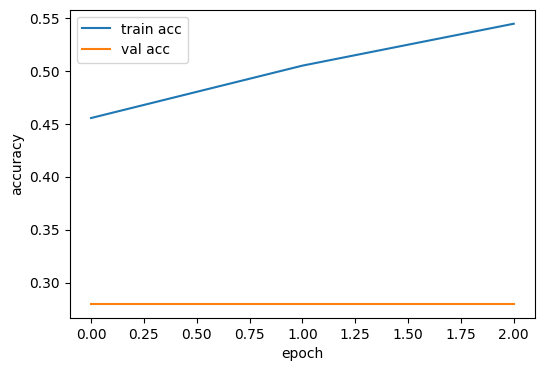

In [166]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(hist.history['accuracy'],     label='train acc')
plt.plot(hist.history['val_accuracy'], label='val acc')
plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.legend(); plt.show()

In [167]:
for imgs, lbls in val.take(1):   # TensorFlow Dataset
    print(lbls.numpy())          # should see mix of 0s and 1s

[[1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]]


In [168]:
import collections
def count_labels(ds, name):
    counter = collections.Counter()
    for _, y in ds.unbatch():
        counter[int(y.numpy())] += 1
    print(f"{name}: {dict(counter)}")

count_labels(train, "train")
count_labels(val,   "val")


/var/folders/0f/3t54p9bx6jb7xqpf28y7tshw0000gn/T/ipykernel_70260/10828580.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  counter[int(y.numpy())] += 1


train: {0: 58, 1: 43}
val: {1: 18, 0: 7}


2025-06-27 11:03:02.218545: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


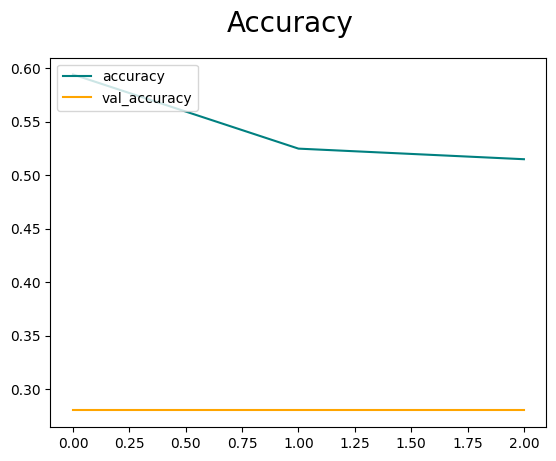

In [108]:
# Show our accuracy (should be increasing)
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 10. Quick Test-Throw in our own image

Let's put our image into the model and see how well it does. 

TypeError: Image data of dtype object cannot be converted to float

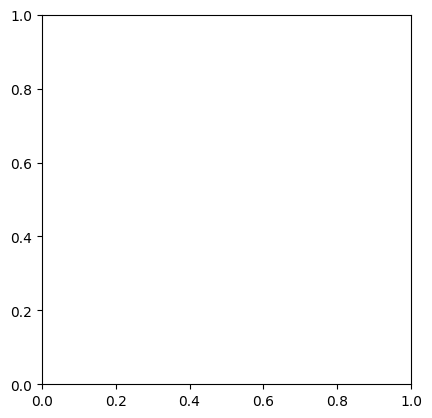

In [88]:

import cv2
img = cv2.imread('random')
plt.imshow(img)
plt.show()

In [1]:
# Resize the image
resize = tf.image.resize(img, (100, 100))

# Convert GBR to RGB by reordering the channels
resize_rgb = tf.reverse(resize, axis=[-1])

# Display the corrected RGB image
plt.imshow(resize_rgb.numpy().astype(int))
plt.show()

NameError: name 'tf' is not defined

In [73]:
# The following line just wraps our image in another set of parenthesis
# This allows the argmax call to work
np.expand_dims(resize_rgb, 0).shape
yhat = model.predict(np.expand_dims(resize_rgb/255, 0))

# This takes the argmax (shows us our predicted class)
predicted_class_index = np.argmax(yhat[0])
print(predicted_class_index)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
73


However, we want more than just the class number... we want its name

This is the (kind of) gross and inefficient way I found of doing it...
Feel free to implement this differently if you like- perhaps by outputting the dictionary then hardcoding it

In [ ]:
# Goes through your directory, sorts each name alphabetically.
# Tensorflow will sort your directory alphabetically, so this match names to the previous cell's number
directory_names = sorted([name for name in os.listdir("train_data") if os.path.isdir(os.path.join("train_data", name))])

graphs_dict = {}

for index, name in enumerate(directory_names):
    graphs_dict.update({index: name})

graph = graphs_dict[predicted_class_index]

print(graph)

Pear Red 1


# 11. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

# After running this cell, you should have a black-box like predictor file
model.save('graphclassifier.keras')
new_model = load_model('graphclassifier.keras')